In [3]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version in torch:", torch.version.cuda)
print("Is torch built with CUDA:", torch.backends.cuda.is_built())


Torch version: 2.4.1+cpu
CUDA available: False
CUDA version in torch: None
Is torch built with CUDA: False


In [4]:
device = "cpu"

import numpy as np
import torch.nn as nn
import torch.nn.functional as F


In [5]:
import json

with open("../tokenizer_data/vocab.json", "r", encoding="utf-8") as f:
    vocab = json.load(f)

vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Vocabulary size: 2439


In [6]:
flattened = np.memmap(
    "../tokenized_sql_dataset/flatten_token.memmap",
    dtype=np.int32,
    mode="r"
)

In [7]:
class DataLoader:
    def __init__(self, memmap_path: str, block_size: int, dtype = np.int32, start=0, end=None):
        self.tokens =  np.memmap(memmap_path, dtype=dtype, mode='r')
        self.block_size = block_size
        self.total_tokens = len(self.tokens)

        self.end = len(self.tokens) - block_size if end is None else end
        self.start = start
        self.length = self.end - self.start


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        idx += self.start
        if idx + self.block_size + 1 > self.end:
            raise IndexError("Index out of bounds.")
        block = self.tokens[idx : idx + self.block_size + 1]
        x = torch.tensor(block[:-1], dtype=torch.long)
        y = torch.tensor(block[1:], dtype=torch.long)
        return x, y

    def get_batch(self, batch_size: int, device='cpu'):
        idxs = np.random.randint(0, self.length, size=batch_size)
        x_list, y_list = zip(*[self[i] for i in idxs])
        x = torch.stack(x_list).to(device)
        y = torch.stack(y_list).to(device)
        return x, y

    @staticmethod
    def collate_fn(batch):
        x = torch.stack([item[0] for item in batch])
        y = torch.stack([item[1] for item in batch])
        return x, y

In [8]:
n_data = len(flattened)
n_data

train_batch_size = 16  # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 256  # number of tokens processed in a single batch
block_size = 256
train_split = 0.9  # percentage of data to use from total data for training

In [9]:
usable_tokens = n_data - block_size
split_ratio = 0.9
split_index = int(usable_tokens * split_ratio)

In [10]:
memmap_path = "../tokenized_sql_dataset/flatten_token.memmap"

train_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=0,
        end=split_index
    )

eval_loader = DataLoader(
        memmap_path=memmap_path,
        block_size=block_size,
        dtype=np.int32,
        start=split_index,
        end=usable_tokens  # to avoid index errors
    )


In [11]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, d_model) # word token embeddings
        self.lm_head = nn.Linear(d_model, vocab_size)

    # def forward(self, inputs, targets = None):
    #     logits = self.wte(inputs) # dim -> batch_size, sequence_length, d_model
    #     loss = None
    #     if targets != None:
    #         batch_size, sequence_length, d_model = logits.shape
    #         # to calculate loss for all token embeddings in a batch
    #         # kind of a requirement for cross_entropy
    #         logits = logits.view(batch_size * sequence_length, d_model)
    #         targets = targets.view(batch_size * sequence_length)
    #         loss = F.cross_entropy(logits, targets)
    #     return logits, loss

    def forward(self, inputs, targets=None):
        x = self.wte(inputs)                                   # [B, T, d_model]
        logits = self.lm_head(x)                               # [B, T, vocab_size]

        loss = None
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B * T, V)                     # flatten for CE
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        # this will store the model outputs along with the initial input sequence
        # make a copy so that it doesn't interfare with model
        for _ in range(max_new_tokens):
            # we only pass targets on training to calculate loss
            logits, _ = self(inputs)
            # for all the batches, get the embeds for last predicted sequence
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            # get the probable token based on the input probs
            idx_next = torch.multinomial(probs, num_samples=1)

            inputs = torch.cat([inputs, idx_next], dim=1)
        # as the inputs has all model outputs + initial inputs, we can use it as final output
        return inputs

In [12]:
basic_model = GPT(vocab_size=2439, d_model=256).to(device)
lr = 1e-3
optimizer = torch.optim.AdamW(basic_model.parameters(), lr=lr)

In [14]:
from tqdm import trange, tqdm

epochs = 1000
eval_steps = 50  # perform evaluation every n steps

train_loss = {}

for ep in trange(epochs, desc="Training Epochs"):
    xb, yb = train_loader.get_batch(train_batch_size, device)

    logits, loss = basic_model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    train_loss[ep] = loss.item()

    if ep % eval_steps == 0 or ep == epochs - 1:
        basic_model.eval()
        with torch.no_grad():
            xvb, yvb = eval_loader.get_batch(eval_batch_size, device)
            _, e_loss = basic_model(xvb, yvb)

            tqdm.write(f"Epoch: {ep}\ttrain_loss: {loss.item():.4f}\teval_loss: {e_loss.item():.4f}")
        basic_model.train()  # back to training mode


Training Epochs:   0%|          | 1/1000 [00:00<01:48,  9.21it/s]

Epoch: 0	train_loss: 2.8865	eval_loss: 3.3532


Training Epochs:   5%|▌         | 52/1000 [00:05<02:00,  7.88it/s]

Epoch: 50	train_loss: 2.9584	eval_loss: 3.3902


Training Epochs:  10%|█         | 102/1000 [00:11<01:39,  9.02it/s]

Epoch: 100	train_loss: 3.0690	eval_loss: 3.3589


Training Epochs:  15%|█▌        | 152/1000 [00:16<01:31,  9.24it/s]

Epoch: 150	train_loss: 3.0170	eval_loss: 3.1861


Training Epochs:  20%|██        | 201/1000 [00:21<01:26,  9.23it/s]

Epoch: 200	train_loss: 3.0002	eval_loss: 3.3831


Training Epochs:  25%|██▌       | 252/1000 [00:27<01:29,  8.34it/s]

Epoch: 250	train_loss: 2.7667	eval_loss: 3.2361


Training Epochs:  30%|███       | 302/1000 [00:32<01:27,  7.98it/s]

Epoch: 300	train_loss: 2.9067	eval_loss: 3.3637


Training Epochs:  35%|███▌      | 352/1000 [00:38<01:12,  8.90it/s]

Epoch: 350	train_loss: 2.9473	eval_loss: 3.3467


Training Epochs:  40%|████      | 402/1000 [00:43<01:06,  8.94it/s]

Epoch: 400	train_loss: 2.6214	eval_loss: 3.4501


Training Epochs:  45%|████▌     | 452/1000 [00:48<00:56,  9.72it/s]

Epoch: 450	train_loss: 2.9152	eval_loss: 3.2422


Training Epochs:  50%|█████     | 502/1000 [00:53<00:52,  9.46it/s]

Epoch: 500	train_loss: 2.7530	eval_loss: 3.4029


Training Epochs:  55%|█████▌    | 553/1000 [00:59<00:45,  9.75it/s]

Epoch: 550	train_loss: 2.9565	eval_loss: 3.3414


Training Epochs:  60%|██████    | 602/1000 [01:04<00:43,  9.19it/s]

Epoch: 600	train_loss: 2.7141	eval_loss: 3.1845


Training Epochs:  65%|██████▌   | 653/1000 [01:09<00:36,  9.51it/s]

Epoch: 650	train_loss: 2.8714	eval_loss: 3.4138


Training Epochs:  70%|███████   | 702/1000 [01:14<00:32,  9.11it/s]

Epoch: 700	train_loss: 2.9043	eval_loss: 3.3969


Training Epochs:  75%|███████▌  | 752/1000 [01:19<00:26,  9.35it/s]

Epoch: 750	train_loss: 2.9153	eval_loss: 3.1347


Training Epochs:  80%|████████  | 801/1000 [01:24<00:20,  9.68it/s]

Epoch: 800	train_loss: 2.9028	eval_loss: 3.3359


Training Epochs:  85%|████████▌ | 853/1000 [01:30<00:14,  9.84it/s]

Epoch: 850	train_loss: 2.7115	eval_loss: 3.3691


Training Epochs:  90%|█████████ | 902/1000 [01:35<00:11,  8.60it/s]

Epoch: 900	train_loss: 2.8674	eval_loss: 3.2802


Training Epochs:  95%|█████████▌| 952/1000 [01:40<00:05,  8.70it/s]

Epoch: 950	train_loss: 2.8034	eval_loss: 3.4351


Training Epochs: 100%|██████████| 1000/1000 [01:45<00:00,  9.48it/s]

Epoch: 999	train_loss: 2.8648	eval_loss: 3.2998


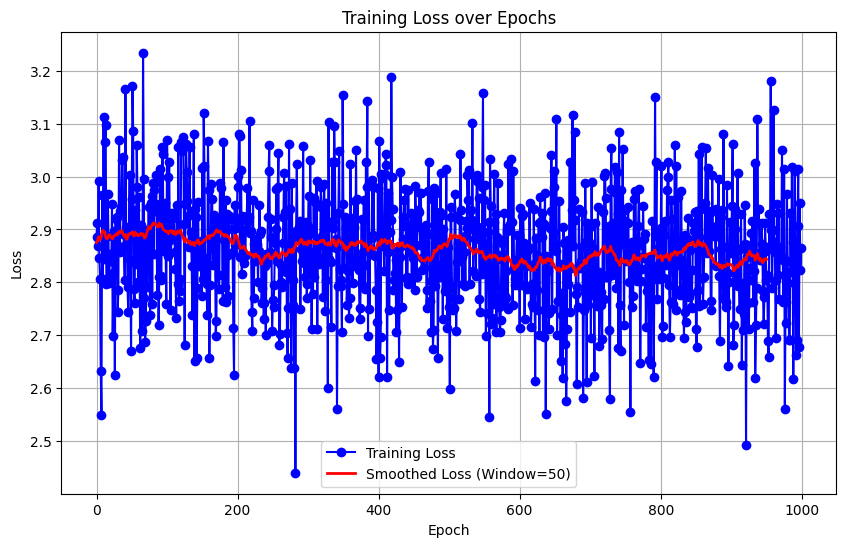

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [2]:
from bpe.fast_token import FastBPETokenizer
tokenizer = FastBPETokenizer()

tokenizer.load("../tokenizer_data")
tokens = tokenizer.tokenize_to_ids("find")

In [18]:
input_tokens = torch.tensor(tokenizer.tokenize_to_ids("If you want to predict/generate outputs on your model right after training without saving and loading, its very straightforward: just keep using your model instance in memory"), dtype=torch.long)

In [19]:
basic_model.eval()

with torch.no_grad():
    logits, _ = basic_model(input_tokens)
    predicted_ids = torch.argmax(logits, dim=-1)  # pick the most likely token at each position

print("Predicted token IDs:", predicted_ids)


Predicted token IDs: tensor([ 81,  66,  59,  36,   9,  90, 164, 207, 258, 115, 111, 238, 132,  94,
         36, 136, 132,  61, 267, 254,  94, 115, 164,   9, 259, 230, 249,   9,
         90, 252, 198, 259, 273, 255, 207, 183, 191,  94, 182,  94, 230, 252,
        182, 198, 149, 264, 208, 107, 182,  93,  94, 252, 198,  89,   7,  99,
          9,  97, 259, 118, 230, 255,  94, 198,  90, 129, 238, 189, 140,  89,
        207, 136,  89,  89, 182,  89, 182, 230, 249,   9,  90, 252, 198, 259,
        252, 118, 164, 259, 264, 252,  90, 254, 259,  37])
